# Question A4

In this section, we will understand the utility of such a neural network in real world scenarios.

#### Please use the real record data named ‘record.wav’  as a test sample. Preprocess the data using the provided preprocessing script (data_preprocess.ipynb) and prepare the dataset.
Do a model prediction on the sample test dataset and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons.
Find the most important features on the model prediction for the test sample using SHAP. Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5,
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195)



1. Firstly, we import relevant libraries.

In [15]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

To reduce repeated code, place your
network (MLP defined in QA1)
torch datasets (CustomDataset defined in QA1)
loss function (loss_fn defined in QA1)
in a separate file called common_utils.py

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.


In [16]:
from common_utils import preprocess, CustomDataset, split_dataset, preprocess_dataset, EarlyStopper

# Define the loss function: Binary Cross Entropy Loss for binary classification
loss_fn = nn.BCELoss()

# Define a Neural Network (MLP) with 2 hidden layers; identified as optimal hyperparameter configuration
class MLP(nn.Module):
    
    def __init__(self, no_features, no_hidden=128, no_labels=1):
        super(MLP, self).__init__()
        
        # Initialize the MLP layers using nn.Sequential
        self.mlp_stack = nn.Sequential(
            # First hidden layer with ReLU activation and dropout
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # Dropout for regularization

            # Second hidden layer with ReLU activation and dropout
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # Dropout for regularization

            # Output layer with sigmoid activation to produce probabilities for binary classification
            nn.Linear(no_hidden, no_labels),
            nn.Sigmoid()  # Sigmoid for output probabilities
        )

    def forward(self, x):
        # Forward propagate the input through the network
        return self.mlp_stack(x)


2. Install and import shap

In [17]:
!pip install shap
import shap


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


3. Read the csv data preprocessed from 'record.wav', using variable name 'df', and fill the size of 'df' in 'size_row' and 'size_column'.

In [25]:
# Load the dataset and get its shape
df = pd.read_csv('new_record.csv')
num_rows, num_columns = df.shape

# Print the dataset dimensions
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")


Number of rows: 1
Number of columns: 78


In [23]:
# Load the dataset from a CSV file
simplified = pd.read_csv('simplified.csv')

# Extract labels from the 'filename' column, where the label is the second-to-last part of the filename
simplified['label'] = simplified['filename'].str.split('_').str[-2]

# Define columns to drop from the dataset, as 'filename' is not useful for analysis and 'label' will be the prediction target
col_drop = ["filename", "label"]

# Preprocess the dataset by splitting into training and testing sets and scaling the features
X_train_scaled, y_train, X_test_scaled, y_test = preprocess(simplified, col_drop=col_drop)


In [26]:
# Print the shapes of the scaled training and testing sets with more descriptive output
print(f"Training set shape (features): {X_train_scaled.shape}")
print(f"Testing set shape (features): {X_test_scaled.shape}")


Training set shape (features): (9645, 77)
Testing set shape (features): (2412, 77)


 4.  Preprocess to obtain the test data, save the test data as numpy array.

In [27]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

def preprocess(X_train, df):
    """ 
    Preprocess the test dataset by scaling it based on the scaler fitted on the training data.
    Ensures compatibility in feature shapes between train and test datasets. 
    """
    # Drop the 'filename' column if it exists as it's not used in model training
    if 'filename' in df.columns:
        X_test = df.drop('filename', axis=1)
    else:
        X_test = df.copy()

    # Convert any bracketed strings in the 'tempo' column to float
    if 'tempo' in X_test.columns:
        X_test['tempo'] = X_test['tempo'].apply(lambda x: float(x.strip('[]')) if isinstance(x, str) else x)

    # Initialize and fit the StandardScaler on X_train to ensure consistency
    scaler = StandardScaler().fit(X_train)

    # Scale the test set using the previously fitted scaler
    X_test_scaled = scaler.transform(X_test)

    return X_test_scaled

# Define columns to drop for getting features
col_drop = ["filename", "label"]
X_train = simplified.drop(columns=col_drop)

# Assuming df contains the test data loaded from 'new_record.csv'
X_test_scaled_instance = preprocess(X_train, df)

# Display the shape of the processed test dataset to confirm it aligns with the training data
print(f"Shape of the scaled test data: {X_test_scaled_instance.shape}")


Shape of the scaled test data: (1, 77)


5. Do a model prediction on the sample test dataset and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. Note: Please define the variable of your final predicted label as 'pred_label'.

In [31]:
# Initialize the DataLoaders
def intialise_dataloader(X_train_scaled_fold, y_train_fold, X_val_scaled_fold, y_val_fold, batch_size):
    # Instantiate the CustomDataset for training and validation
    train_dataset = CustomDataset(X_train_scaled_fold, y_train_fold)
    val_dataset = CustomDataset(X_val_scaled_fold, y_val_fold)

    # Initialize DataLoaders with specified batch size and shuffling for training
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, validation_dataloader


def training_loop(dataloader, model, loss_fn, optimizer):
    train_loss, correct_predictions = 0, 0
    total_samples = 0

    for x, y in dataloader:
        pred = model(x)
        y = y.unsqueeze(1).float()  # Ensure labels are the same shape as predictions

        # Calculate loss and perform backpropagation
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        # Convert model outputs to binary predictions and accumulate correct predictions
        predicted_labels = (pred > 0.5).float()
        correct_predictions += (predicted_labels == y).float().sum().item()
        total_samples += y.size(0)

    # Calculate average loss and accuracy for the epoch
    train_loss /= len(dataloader)
    accuracy = correct_predictions / total_samples

    return train_loss, accuracy


def validation_loop(dataloader, model, loss_fn):
    val_loss, correct_predictions = 0, 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for x, y in dataloader:
            pred = model(x)
            y = y.unsqueeze(1).float()  # Ensure labels are the same shape as predictions

            # Calculate loss
            val_loss += loss_fn(pred, y).item()

            # Convert model outputs to binary predictions and accumulate correct predictions
            predicted_labels = (pred > 0.5).float()
            correct_predictions += (predicted_labels == y).float().sum().item()
            total_samples += y.size(0)

    # Calculate average loss and accuracy for the epoch
    val_loss /= len(dataloader)
    accuracy = correct_predictions / total_samples

    return val_loss, accuracy


In [34]:
# Model and training parameters determined from Hyperband tuning in Part A_3
no_features = 77  # Number of input features
no_hidden = 256   # Number of neurons in the hidden layer
no_labels = 1     # Number of output labels (binary classification)

batch_size = 256  # Batch size for training
no_epochs = 100   # Maximum number of epochs
lr = 0.000899393072612008  # Learning rate

# Initialize the model, optimizer, and early stopping mechanism
model = MLP(no_features, no_hidden, no_labels)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
early_stopper = EarlyStopper(patience=5, min_delta=0.0001)

# Set up DataLoaders for training and validation
train_dataloader, val_dataloader = intialise_dataloader(X_train_scaled, y_train, X_test_scaled, y_test, batch_size)

# Lists to store training and validation loss/accuracy over epochs
train_loss_, train_acc_ = [], []
val_loss_, val_acc_ = [], []

# Training loop
for epoch in range(no_epochs):
    # Perform training step and validation step
    train_loss, train_acc = training_loop(train_dataloader, model, loss_fn, optimizer)
    val_loss, val_acc = validation_loop(val_dataloader, model, loss_fn)
    
    # Store results for each epoch
    train_loss_.append(train_loss), train_acc_.append(train_acc)
    val_loss_.append(val_loss), val_acc_.append(val_acc)
    
    # Print results every 5 epochs
    if epoch % 5 == 0:
        print(f"Epoch: {epoch}\n\ttrain_loss: {train_loss}\ttrain_acc: {train_acc}")
        print(f"\tval_loss: {val_loss}\tval_acc: {val_acc}")

    # Check for early stopping condition
    if early_stopper.early_stop(val_loss):
        print(f"Early stopping triggered at epoch {epoch}")
        break

# Prediction on a new instance
pred = model(torch.tensor(X_test_scaled_instance, dtype=torch.float32))

# Convert the output to a binary label (0 or 1) based on the threshold
pred_label = (pred > 0.5).float().item()  # Convert probability to binary label
print(f"Predicted label: {pred_label}")


Epoch: 0
	train_loss: 0.6806224961029855	train_acc: 0.5663037843442198
	val_loss: 0.6736398041248322	val_acc: 0.5796019900497512
Epoch: 5
	train_loss: 0.5996846274325722	train_acc: 0.6737169517884914
	val_loss: 0.6269919753074646	val_acc: 0.6451077943615257
Epoch: 10
	train_loss: 0.5136634495697523	train_acc: 0.7477449455676516
	val_loss: 0.5878211915493011	val_acc: 0.6919568822553898
Epoch: 15
	train_loss: 0.45319954658809464	train_acc: 0.7868325557283566
	val_loss: 0.5745672762393952	val_acc: 0.7093698175787728
Epoch: 20
	train_loss: 0.3995874147666128	train_acc: 0.822291342664593
	val_loss: 0.5610690712928772	val_acc: 0.7313432835820896
Epoch: 25
	train_loss: 0.34801287949085236	train_acc: 0.8442716433385173
	val_loss: 0.546849250793457	val_acc: 0.7441956882255389
Epoch: 30
	train_loss: 0.33097430279380397	train_acc: 0.855883877656817
	val_loss: 0.5246451467275619	val_acc: 0.7566334991708126
Epoch: 35
	train_loss: 0.2850632612642489	train_acc: 0.881078278900985
	val_loss: 0.54891067

6. Find the most important features on the model prediction for your test sample using SHAP. Create an instance of the DeepSHAP which is called DeepExplainer using traianing dataset: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html.

Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5,
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195)


In [ ]:
'''
Fit the explainer on a subset of the data (you can try all but then gets slower)
Return approximate SHAP values for the model applied to the data given by X.
Plot the local feature importance with a force plot and explain your observations.
'''
# YOUR CODE HERE

In [53]:
import pandas as pd

# Load the dataset and drop the 'filename' column if it exists
file_path = 'new_record.csv'
try:
    df = pd.read_csv(file_path)
    if 'filename' in df.columns:
        df = df.drop(columns=['filename'])
    else:
        print("'filename' column not found. Proceeding without dropping.")

    # Display the DataFrame
    display(df)

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please check the file path.")
except pd.errors.EmptyDataError:
    print("Error: The file is empty. Please provide a valid CSV file.")
except Exception as e:
    print(f"An error occurred: {e}")


,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,melspectrogram_mean,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,[112.34714674],280,70.0,0.478361,0.111058,0.579547,0.091646,0.268037,0.01149,0.021869,...,-4.068467,46.23243,-4.134901,53.040028,-0.942353,35.105545,-3.529712,54.78144,-3.722852,53.242016


In [59]:
# Ensure X_train_scaled is 2D: [num_samples, num_features]
X_train_scaled_tensor = torch.tensor(X_train_scaled, dtype=torch.float)

# Ensure x_test_instance is 2D: [1, num_features] for a single sample
x_test_instance_tensor = torch.tensor(X_test_scaled_instance, dtype=torch.float)

In [63]:
# Initialize the SHAP DeepExplainer with the model and the training data
explainer = shap.DeepExplainer(model, X_train_scaled_tensor)

# 1. Initialize SHAP DeepExplainer with the model and the training data
explainer = shap.DeepExplainer(model, X_train_scaled_tensor)

# 2. Get SHAP values for the test instance
shap_values = explainer.shap_values(x_test_instance_tensor)

# 3. Visualize the SHAP values using a force plot
shap.initjs()

# Reshape SHAP values to match the input instance shape
shap_values_reshaped = shap_values[0].reshape(1, -1)  # Reshape (77, 1) to (1, 77)

# Check the shapes after reshaping
print(f"The SHAP reshaped: {shap_values_reshaped.shape}")
print(f"The Test instance shape: {x_test_instance_tensor.shape}")

# Visualize the force plot
shap.force_plot(explainer.expected_value[0], shap_values_reshaped[0], x_test_instance_tensor.numpy())


The SHAP reshaped: (1, 77)
The Test instance shape: torch.Size([1, 77])


SHAP values reshaped: (1, 77)
Test instance shape: torch.Size([1, 77])


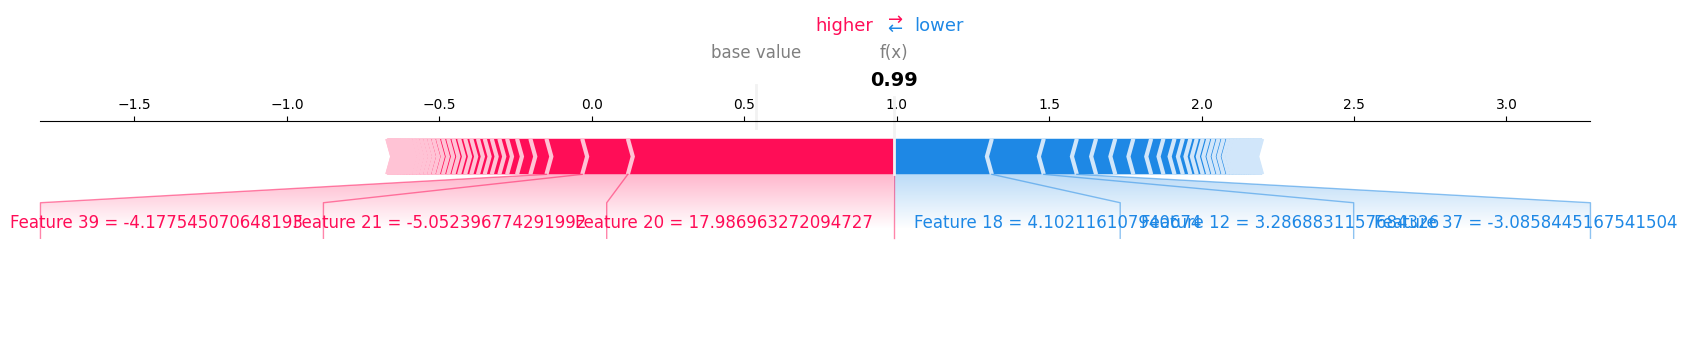

In [65]:
import torch
import shap

# Ensure the model and tensors are on the appropriate device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
X_train_scaled_tensor = X_train_scaled_tensor.to(device, dtype=torch.float32)
x_test_instance_tensor = x_test_instance_tensor.to(device, dtype=torch.float32)

# 1. Initialize SHAP DeepExplainer with the model and the training data on the correct device
explainer = shap.DeepExplainer(model, X_train_scaled_tensor)

try:
    # 2. Calculate SHAP values for the test instance
    shap_values = explainer.shap_values(x_test_instance_tensor)
    
    # 3. Visualize the SHAP values using a force plot with matplotlib
    shap_values_reshaped = shap_values[0].reshape(1, -1)  # From (77, 1) to (1, 77)
    print(f"SHAP values reshaped: {shap_values_reshaped.shape}")
    print(f"Test instance shape: {x_test_instance_tensor.shape}")
    
    x_test_instance_tensor_np = x_test_instance_tensor.cpu().detach().numpy()
    
    # Use matplotlib for force plot
    shap.force_plot(explainer.expected_value[0], shap_values_reshaped[0], 
                    x_test_instance_tensor_np, matplotlib=True)
    
except Exception as e:
    print(f"An error occurred while calculating SHAP values or plotting: {e}")


Reshaped SHAP values: (77,)
Feature count: 77


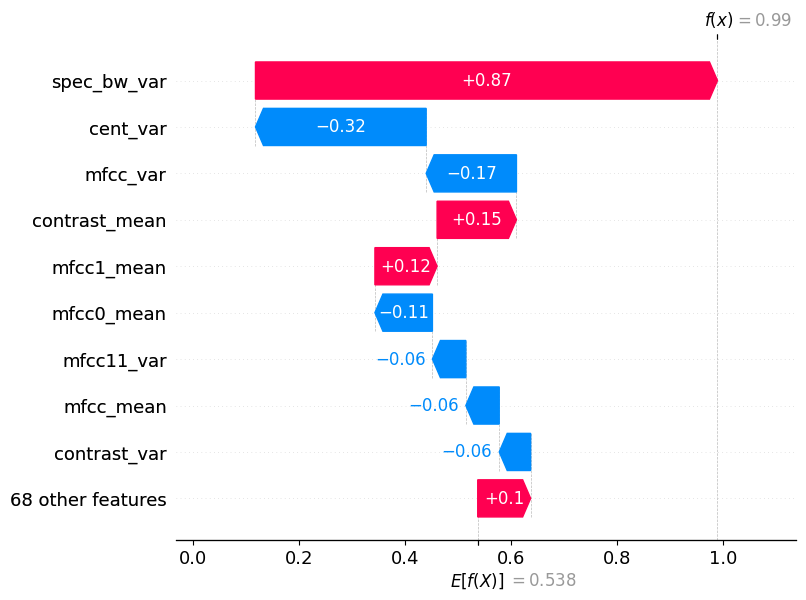

In [72]:
# Import necessary libraries
import shap

# Ensure the reshaped SHAP values match the expected format for the waterfall plot
try:
    # Flatten the SHAP values to 1D to match the number of features
    reshaped_shap_values = shap_values[0].flatten()

    # Print to confirm shapes are consistent
    print(f"Reshaped SHAP values: {reshaped_shap_values.shape}")
    print(f"Feature count: {len(df.columns)}")

    # Visualize the SHAP values using the waterfall plot
    shap.waterfall_plot(
        shap.Explanation(values=reshaped_shap_values, 
                         base_values=explainer.expected_value[0], 
                         feature_names=df.columns)
    )
    
except Exception as e:
    print(f"An error occurred during the SHAP waterfall plot visualization: {e}")


# Model Prediction Analysis

### Overview
- **Base Value (E[f(x)])**: The base value is approximately **0.538**, indicating the expected output if features had no impact. This might reflect any class imbalance or model bias in the training data.
- **Output Value (f(x))**: The model's final prediction is **0.99**, which is above 0.5, suggesting a **positive class (1)** prediction. This value results from the base value adjusted by feature contributions.

### Feature Contributions
- **Positive Contributions (Red Bars)**: Features that increase the likelihood of predicting a positive class (1).
- **Negative Contributions (Blue Bars)**: Features that decrease the likelihood of predicting a positive class (1).

### Key Features
- **Top Contributor**: The feature **spec_bw_var** strongly pushes the prediction towards the positive class, indicating it significantly influences the outcome.
- **Other Important Features**: Features like **cent_var** and **mfcc_var** have negative impacts, pulling the score lower. However, **spec_bw_var** remains dominant, driving the prediction towards a positive outcome.
